# Activation function for a LIFE

This script investigates the activation function for a longitudinal intrafascicular electrode (LIFE). It is similar to the previous example but include geometrical considerationc, and computations are ran in FEM in background (transparent for user).

NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 4414
NRV INFO: Number of elements : 30602
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 2.342923879623413 s
NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 7018
NRV INFO: Number of elements : 48417
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 3.392620086669922 s
NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of

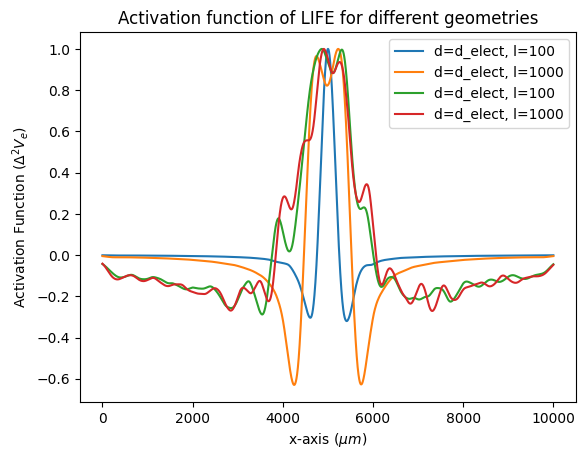

In [4]:
import nrv
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

d_elect_list = [100,500]
LIFE_length_list = [100,1000]

window_length_filter = 501
polyorder_filter = 3
def get_first_derivative(ftp):
    ftp = signal.savgol_filter(ftp, window_length=window_length_filter, polyorder=polyorder_filter, mode="nearest")
    ftp = np.gradient(ftp)
    ftp = signal.savgol_filter(ftp, window_length=window_length_filter, polyorder=polyorder_filter, mode="nearest")
    return(ftp)

def get_second_derivative(ftp):
    ftp=get_first_derivative(ftp)
    ftp = np.gradient(ftp)
    ftp = signal.savgol_filter(ftp, window_length=window_length_filter, polyorder=polyorder_filter, mode="nearest")
    return(ftp)

plt.figure()

for d_elect in d_elect_list:
    for length_1 in LIFE_length_list:
        ##### extracellular context
        test_stim = nrv.FEM_stimulation()

        ### Simulation box size
        Outer_D = 6
        test_stim.reshape_outerBox(Outer_D)

        #### Nerve and fascicle geometry
        L = 10000
        Nerve_D = 1000
        Fascicle_D = 800
        test_stim.reshape_nerve(Nerve_D, L)
        test_stim.reshape_fascicle(Fascicle_D)

        ##### electrodes and stimuli definition
        D_1 = 25
        y_c_1 = 0
        z_c_1 = 0
        x_1_offset = L/2 - (length_1/2)
        elec_1 = nrv.LIFE_electrode('LIFE', D_1, length_1, x_1_offset, y_c_1, z_c_1)
        # stimulus def
        start = 1
        I_cathod = 500
        I_anod = I_cathod/5
        T_cathod = 60e-3
        T_inter = 40e-3
        stim1 = nrv.stimulus()
        stim1.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)
        test_stim.add_electrode(elec_1, stim1)

        ##### run FEM model
        #test_stim.run_model()

        ##### compute footprints
        x = np.linspace(0,L,num=10000)
        y = d_elect
        z = 0
        test_stim.compute_electrodes_footprints(x, y, z, ID=0)

        ftp = elec_1.footprint
        acti_function = get_second_derivative(-ftp)
        acti_function = acti_function/np.max(acti_function)
        plt.plot(x, acti_function, label='d=d_elect'+str()+', l='+str(length_1))
        '''filename = 'LIFE_'+str(length_1)+'_um_delect_' + str(d_elect) + '_um_ftp.csv'

        header = ['x_elect','elect_ftp']
        f = open(filename,"w")
        writer = csv.writer(f)
        writer.writerow(header)
        for k in range(len(x)):
            row = [x[k],elec_1.footprint[k]]
            writer.writerow(row)
        f.close()'''

        del elec_1,test_stim,stim1

plt.ylabel('Activation Function ($\Delta^2V_e$)')
plt.xlabel('x-axis ($\mu m$)')
plt.legend()
plt.title('Activation function of LIFE for different geometries')
plt.show()
